## Basic Linear Regression Model
Building a simple linear regression model to predict total bike rentals (`cnt`) using weather features: temperature, humidity, and windspeed.

### Load dependencies and data

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import mlflow
import mlflow.sklearn
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
%matplotlib inline

# load data
data_dir = Path.cwd()

day_df = pd.read_csv(data_dir / 'day.csv', parse_dates=['dteday'])
hour_df = pd.read_csv(data_dir / 'hour.csv', parse_dates=['dteday'])

# make a normal timeline 2011-01-01 08:00:00
hour_df['datetime'] = hour_df['dteday'] + pd.to_timedelta(hour_df['hr'], unit='h')

print(f"Dataset loaded: {len(hour_df)} records")
print(f"Date range: {hour_df['dteday'].min()} to {hour_df['dteday'].max()}")

Dataset loaded: 17379 records
Date range: 2011-01-01 00:00:00 to 2012-12-31 00:00:00


### Setup MLflow experiment

In [2]:
# Set up MLflow experiment
mlflow.set_experiment("bike-sharing-basic-model")

# Set tracking URI to local directory
mlflow.set_tracking_uri("file:./mlruns")

print("MLflow experiment setup complete!")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment Name: bike-sharing-basic-model")

2025/11/04 17:54:36 INFO mlflow.tracking.fluent: Experiment with name 'bike-sharing-basic-model' does not exist. Creating a new experiment.


MLflow experiment setup complete!
Tracking URI: file:./mlruns
Experiment Name: bike-sharing-basic-model


### Prepare data for regression
We'll use only 3 weather features: temperature, humidity, and windspeed.

In [3]:
# Select features and target
features = ['temp', 'hum', 'windspeed']
target = 'cnt'

# Prepare X (features) and y (target)
X = hour_df[features]
y = hour_df[target]

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print(f"\nFeatures used: {features}")
print(f"Target variable: {target}")

Training set size: 13903 samples
Testing set size: 3476 samples

Features used: ['temp', 'hum', 'windspeed']
Target variable: cnt


### Train the linear regression model

In [4]:
# Start MLflow run
with mlflow.start_run(run_name="basic_linear_regression"):
    
    # Create and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
     
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Log parameters
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("features", features)
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)
    
    # Log model coefficients
    for feature, coef in zip(features, model.coef_):
        mlflow.log_param(f"coef_{feature}", round(coef, 2))
    mlflow.log_param("intercept", round(model.intercept_, 2))
    
    # Log metrics
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_r2", test_r2)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_mae", test_mae)
    
    # Log the model
    mlflow.sklearn.log_model(model, "basic_model")
    
    print("Model trained successfully!")
    print(f"\nModel Coefficients:")
    for feature, coef in zip(features, model.coef_):
        print(f"  {feature}: {coef:.2f}")
    print(f"\nIntercept: {model.intercept_:.2f}")
    print("\n✓ All parameters, metrics, and model logged to MLflow!")

2025/11/04 17:54:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 17:54:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/04 17:54:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model trained successfully!

Model Coefficients:
  temp: 360.56
  hum: -275.93
  windspeed: 19.84

Intercept: 180.48

✓ All parameters, metrics, and model logged to MLflow!


## Evaluate model performance

In [5]:
# Display results
print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print("\nTraining Set:")
print(f"  R² Score:  {train_r2:.4f}")
print(f"  RMSE:      {train_rmse:.2f}")
print(f"  MAE:       {train_mae:.2f}")

print("\nTest Set:")
print(f"  R² Score:  {test_r2:.4f}")
print(f"  RMSE:      {test_rmse:.2f}")
print(f"  MAE:       {test_mae:.2f}")

print("\n" + "="*60)
print(f"The model explains {test_r2*100:.2f}% of the variance in bike rentals")
print("="*60)

MODEL PERFORMANCE METRICS

Training Set:
  R² Score:  0.2500
  RMSE:      157.80
  MAE:       117.96

Test Set:
  R² Score:  0.2562
  RMSE:      153.47
  MAE:       115.16

The model explains 25.62% of the variance in bike rentals


### Visualize predictions vs actual values

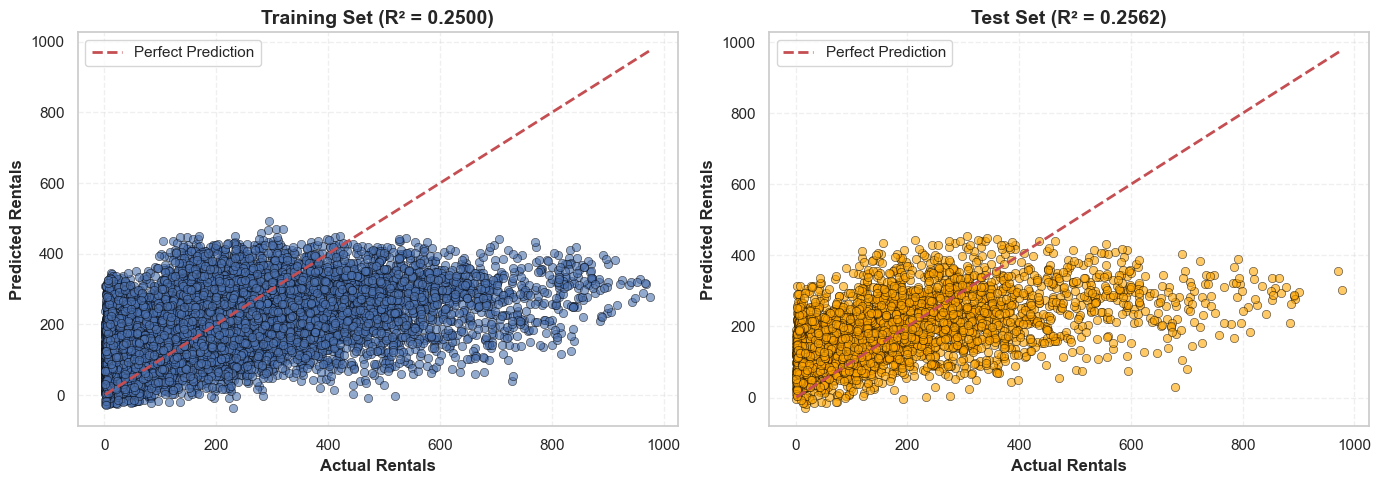

In [6]:
# Create scatter plot of actual vs predicted values using seaborn
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.6, edgecolor='black', linewidth=0.5, ax=axes[0])
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Rentals', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Rentals', fontsize=12, fontweight='bold')
axes[0].set_title(f'Training Set (R² = {train_r2:.4f})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, linestyle='--')

# Test set
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6, color='orange', edgecolor='black', linewidth=0.5, ax=axes[1])
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Rentals', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted Rentals', fontsize=12, fontweight='bold')
axes[1].set_title(f'Test Set (R² = {test_r2:.4f})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### Residual analysis

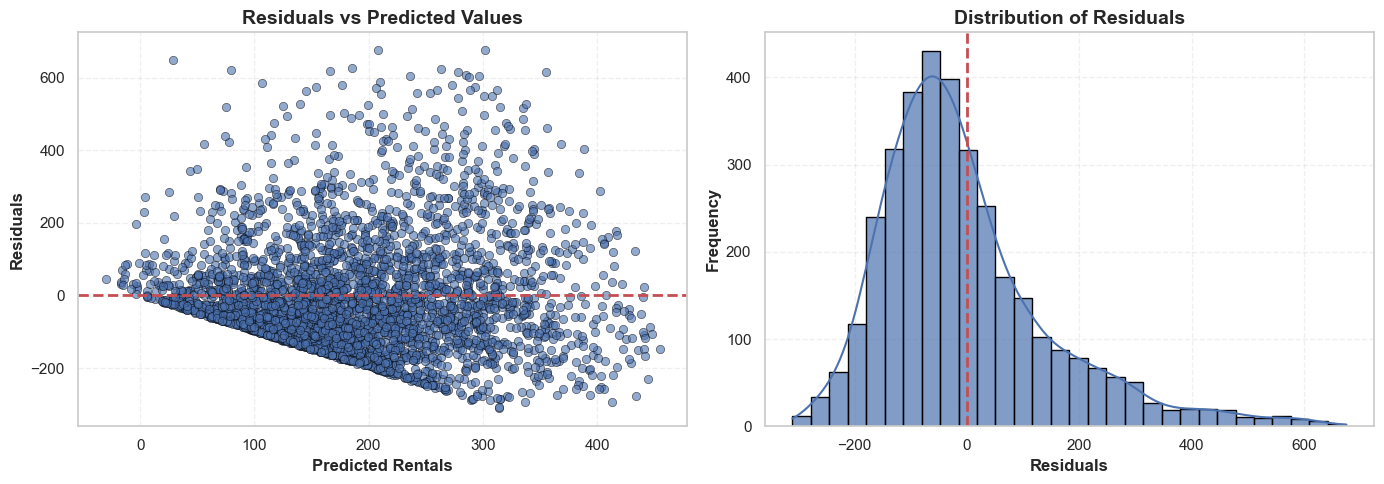

In [7]:
# Calculate residuals
residuals = y_test - y_test_pred

# Create residual plots using seaborn
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs Predicted
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.6, edgecolor='black', linewidth=0.5, ax=axes[0])
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Rentals', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[0].set_title('Residuals vs Predicted Values', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--')

# Histogram of residuals
sns.histplot(residuals, bins=30, kde=True, edgecolor='black', alpha=0.7, ax=axes[1])
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### View MLflow Experiment Results
Query and display the logged experiments and runs from MLflow.

In [8]:
# Search for runs in the experiment
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiment = client.get_experiment_by_name("bike-sharing-basic-model")

if experiment:
    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["start_time DESC"],
        max_results=5
    )
    
    print(f"Experiment: {experiment.name}")
    print(f"Experiment ID: {experiment.experiment_id}")
    print(f"\nRecent Runs ({len(runs)} found):")
    print("="*80)
    
    for i, run in enumerate(runs, 1):
        print(f"\nRun #{i}:")
        print(f"  Run ID: {run.info.run_id}")
        print(f"  Run Name: {run.data.tags.get('mlflow.runName', 'N/A')}")
        print(f"  Status: {run.info.status}")
        print(f"  Start Time: {pd.to_datetime(run.info.start_time, unit='ms')}")
        
        print(f"\n  Metrics:")
        for metric, value in sorted(run.data.metrics.items()):
            print(f"    {metric}: {value:.4f}")
        
        print(f"\n  Parameters:")
        for param, value in sorted(run.data.params.items()):
            if param.startswith('coef_') or param == 'intercept':
                print(f"    {param}: {value}")
    
    print("\n" + "="*80)
    print("\n📊 To view the MLflow UI, run this command in terminal:")
    print("   mlflow ui --backend-store-uri file:./mlruns")
    print("\nThen open: http://localhost:5000")
else:
    print("No experiment found. Please run the model training cell first.")

Experiment: bike-sharing-basic-model
Experiment ID: 293235595320029747

Recent Runs (1 found):

Run #1:
  Run ID: 62792f7881e043f1aceff0a9a095a841
  Run Name: basic_linear_regression
  Status: FINISHED
  Start Time: 2025-11-04 16:54:36.124000

  Metrics:
    test_mae: 115.1557
    test_r2: 0.2562
    test_rmse: 153.4726
    train_mae: 117.9558
    train_r2: 0.2500
    train_rmse: 157.8005

  Parameters:
    coef_hum: -275.93
    coef_temp: 360.56
    coef_windspeed: 19.84
    intercept: 180.48


📊 To view the MLflow UI, run this command in terminal:
   mlflow ui --backend-store-uri file:./mlruns

Then open: http://localhost:5000


## 🔍 Limitations of This Basic Model

This model only uses 3 weather features and achieves an R² of around **0.26**. This means it explains only 26% of the variance in bike rentals.

**What's missing?**
- Temporal patterns: hour of day, day of week, season
- Categorical features: weather conditions, holidays

**Next step:** Check the `encoding_model.ipynb` notebook to see how one-hot encoding can dramatically improve performance!